In [1]:
import os
import json
import pandas as pd
from tqdm import tqdm

In [2]:
def read_json_file(_path):
    with open(_path) as json_file:
        return json.load(json_file)

In [3]:
def get_categories(_category_path, _categories):

    _categories_df = pd.read_csv(_category_path, header=None)

    _categories_dict = {}
    for i, row in _categories_df.iterrows():
        if row[1] in _categories:
            _categories_dict[row[0]] = row[1]

    return _categories_dict

In [4]:
def get_data(_data_path, _category_path, _categories):

    _orig_data = read_json_file(_data_path)

    _categories_dict = get_categories(_category_path, _categories)

    _final_data = []
    for _set_data in tqdm(_orig_data):
        _tmp_items = []
        for _item_data in _set_data["items"]:
            if _item_data["categoryid"] in _categories_dict:
                _item_data["categoryname"] = _categories_dict[_item_data["categoryid"]]
                _item_data["set_id"] = _set_data["set_id"]
                _item_data["id"] = f"{_set_data['set_id']}_{_item_data['index']}"
                _item_data["path"] = f"./../datasets/Polyvore/maryland-polyvore-images-1/maryland-polyvore-images/versions/1/images/{_set_data['set_id']}/{_item_data['index']}.jpg"
                _tmp_items.append(_item_data)

        if len(_tmp_items) > 1:
            _set_data["items"] = _tmp_items
            _final_data.append(_set_data)

    return _final_data

In [5]:
train_set_data = get_data(
    "./../datasets/Polyvore/polyvore/train_no_dup.json",
    "./../datasets/Polyvore/polyvore/categories.csv",
    ["pants", "shirt"]
)

train_item_data = []
for set_data in train_set_data:
    train_item_data += set_data["items"]

pants = []
shirts = []
for d in train_item_data:
    if d["categoryname"] == "pants":
        pants.append(d)
    else:
        shirts.append(d)

pants = pants[:50]
shirts = shirts[:50]

100%|██████████| 17316/17316 [00:00<00:00, 549891.49it/s]


In [10]:
SUGGESTION_SYSTEM_PROMPT = """
SYSTEM:
You are a professional fashion stylist AI.
Your task is to select up to 5 compatible outfit sets (shirt + pants)
from the provided catalog that best match the user’s query or situation.

GUIDELINES:
1. Read the user’s query carefully — infer context such as gender, occasion, season, style (casual, formal, sporty, etc.), and color/brightness preferences.
2. From the given catalog:
   - Choose shirts and pants that match both style and practicality.
   - Prioritize compatibility between chosen shirt and pants (color, pattern, fabric, seasonality).
   - Be diverse — avoid repeating nearly identical outfits.
3. Each outfit set must include exactly one shirt and one pants.
4. Output at most 5 sets, sorted from most to least relevant.
5. For each set, provide a short explanation (20–30 words) explaining why it fits the user’s request.
6. If the catalog is insufficient to fully satisfy the request, make reasonable assumptions and explain them.

INPUT FORMAT:
User query:
"{{user_query}}"

Shirts catalog:
[
  { "id": "shirt_1", "description": "..." },
  { "id": "shirt_2", "description": "..." },
  ...
]

Pants catalog:
[
  { "id": "pants_1", "description": "..." },
  { "id": "pants_2", "description": "..." },
  ...
]

OUTPUT FORMAT (strict JSON):
{
  "outfits": [
    {
      "shirt_id": "shirt_12",
      "pants_id": "pants_5",
      "explanation": "Elegant white blouse with navy slacks — perfect for a semi-formal dinner, comfortable yet sophisticated."
    },
    ...
  ]
}
"""

SUGGESTION_USER_PROMPT = """
User query:
{user_query}

Shirts catalog:
{shirts_catalog}

Pants catalog:
{pants_catalog}
"""


In [14]:
from together import Together
TOGETHER_AI_API_KEY="e83eac84fd3e06a1237468ccd1fac5b13a3e03c07f687a136645bfca19406cc2"
TOGETHER_AI_MODEL_NAME="meta-llama/Llama-3.3-70B-Instruct-Turbo-Free"

def togetherai_retrieve_response(system_prompt: str, user_prompt: str, **kwargs):

    client = Together(api_key=TOGETHER_AI_API_KEY)

    response = client.chat.completions.create(
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
        model=TOGETHER_AI_MODEL_NAME,
    )

    response = response.choices[0].message.content
    print(response)
    response = response.replace("```json", "").replace("```", "")
    return json.loads(response)


In [23]:
OPENROUTER_API_KEY = "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"
OPENROUTER_MODEL_NAME = "meta-llama/llama-3.3-70b-instruct:free"
from openai import OpenAI


def openrouter_get_resp(system_prompt: str, user_prompt: str, **kwargs):
    client = OpenAI(
      base_url="https://openrouter.ai/api/v1",
      api_key=OPENROUTER_API_KEY,
    )

    completion = client.chat.completions.create(
        model=OPENROUTER_MODEL_NAME,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )

    resp = completion.choices[0].message.content
    start_idx = resp.index("```json") + len("```json")
    resp = resp[start_idx:]
    print(resp)
    resp = resp.replace("```json", "").replace("```", "")
    resp = json.loads(resp)

    return resp


In [30]:
query = "I need a bright and formal set for a dinner date"
shirts_catalog = [{"id": c["id"], "description": c["name"]} for c in shirts]
pants_catalog = [{"id": c["id"], "description": c["name"]} for c in pants]

In [31]:
resp = openrouter_get_resp(
    SUGGESTION_SYSTEM_PROMPT,
    SUGGESTION_USER_PROMPT.format(user_query=query, shirts_catalog=shirts_catalog, pants_catalog=pants_catalog),
)


{
  "outfits": [
    {
      "shirt_id": "202255709_1",
      "pants_id": "216657470_3",
      "explanation": "Khaki crochet halter neck crop top with carven striped metallic pants, a bright and elegant combination."
    },
    {
      "shirt_id": "216642765_3",
      "pants_id": "215478175_3",
      "explanation": "Elegant fashion women love heart printed long sleeved round neck t-shirt with roksanda wool-blend cropped trousers, a romantic and formal pair."
    },
    {
      "shirt_id": "191646419_1",
      "pants_id": "209591062_3",
      "explanation": "Shein sheinside multicolor spaghetti strap boho bohemian top with missoni straight-leg pants, a vibrant and stylish choice."
    },
    {
      "shirt_id": "205736516_1",
      "pants_id": "215668984_2",
      "explanation": "Topshop sleeveless skinny rib crop top with stretch-cotton wide-leg pants, a chic and modern outfit."
    },
    {
      "shirt_id": "207602996_1",
      "pants_id": "215100879_3",
      "explanation": "Proenz

In [32]:
result = resp["outfits"]

Khaki crochet halter neck crop top with carven striped metallic pants, a bright and elegant combination.


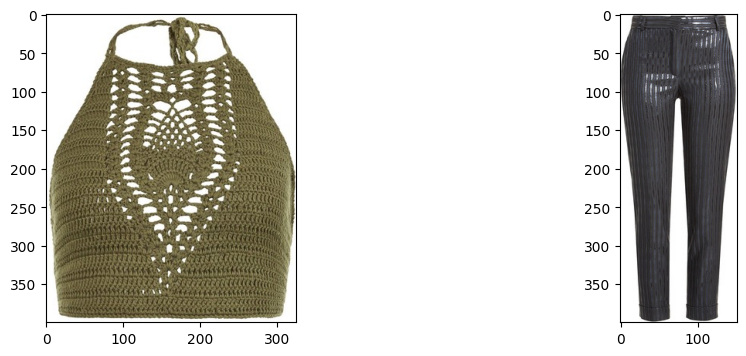

Elegant fashion women love heart printed long sleeved round neck t-shirt with roksanda wool-blend cropped trousers, a romantic and formal pair.


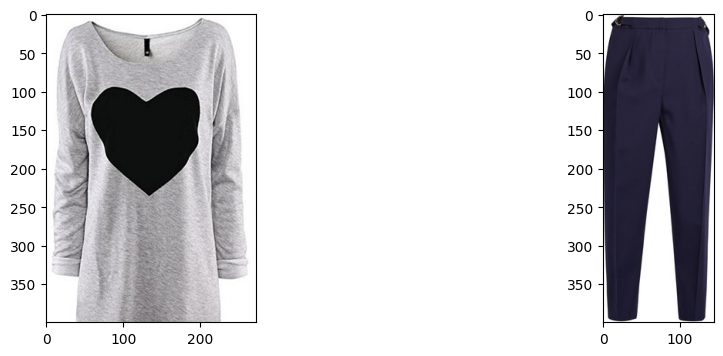

Shein sheinside multicolor spaghetti strap boho bohemian top with missoni straight-leg pants, a vibrant and stylish choice.


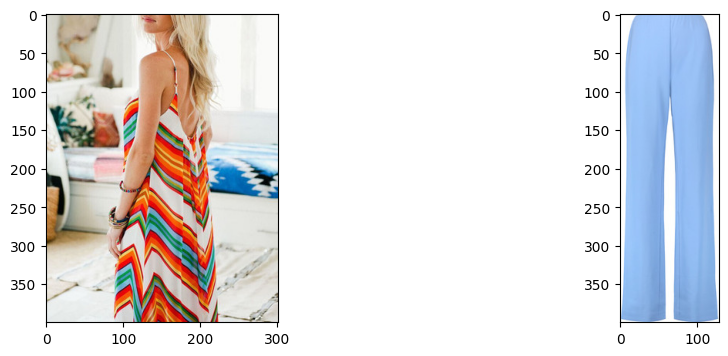

Topshop sleeveless skinny rib crop top with stretch-cotton wide-leg pants, a chic and modern outfit.


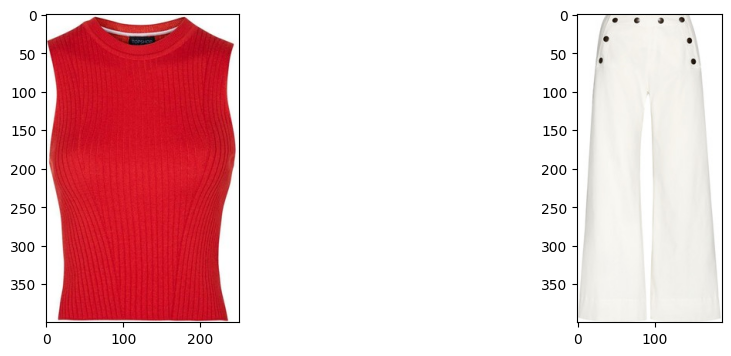

Proenza schouler striped slub cotton top with haider stripes leggings, a fashionable and comfortable option.


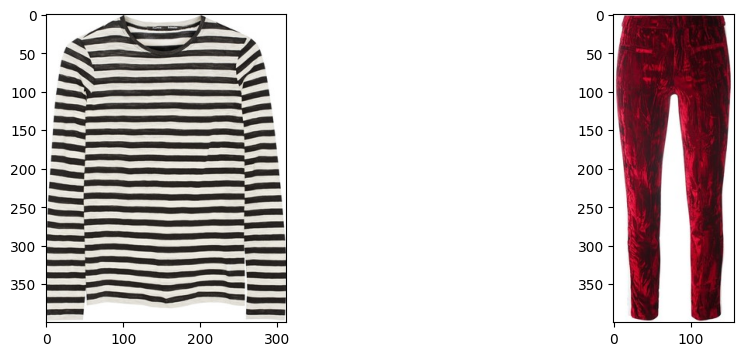

In [34]:
import matplotlib.pyplot as plt
from PIL import Image

for x in result:
    try:
        print(x["explanation"])
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        img1 = list(filter(lambda z: z["id"] == x["shirt_id"], shirts))[0]["path"]
        img1 = Image.open(img1).convert("RGB")
        axes[0].imshow(img1)

        img2 = list(filter(lambda z: z["id"] == x["pants_id"], pants))[0]["path"]
        img2 = Image.open(img2).convert("RGB")
        axes[1].imshow(img2)
        plt.show()
    except Exception as e:
        print(repr(e))
        pass